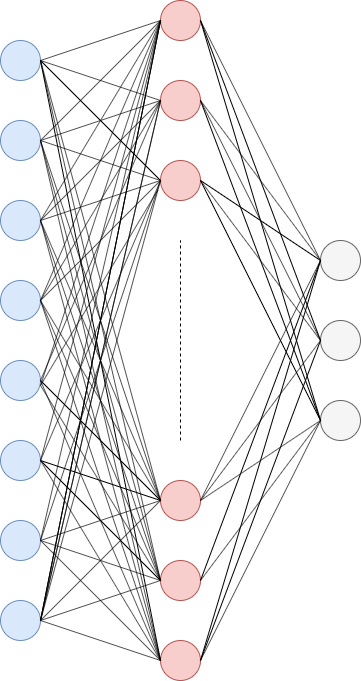

In [1]:
import pandas as pd
import numpy as np
import csv
colNames = ['class', 'ra'
            , 'dec', 'u', 'g', 'r', 'i', 'z', 'nuv_mag']

dataSet = pd.read_csv('../GALEX_data-extended-feats.csv', usecols = colNames)
layers = [8, 32, 3]
dataSet = pd.DataFrame(dataSet)

In [2]:
def sig(z):
    return (1)/(1 + np.exp(-z))

def sig_prime(z):
    return sig(z)*(1-sig(z))

def tanH(z):
    return np.tanh(z)

def tanH_prime(z):
    return 1 - ((tanH(z))**2)

In [3]:
weightsHidden = np.array(np.random.randn(layers[1], layers[0]))*(np.sqrt(2/(layers[1] + layers[0])))
biasHidden = np.zeros(layers[1])
weightsOut = np.array(np.random.randn(layers[2], layers[1]))*(np.sqrt(2/(layers[1] + layers[2])))
biasOut = np.zeros(layers[2])
testDf = dataSet.sample(frac = 0.2, random_state = 3)

In [4]:
def expec(inp):
    if inp == 0:
        return np.array([1, 0, 0])
    elif inp == 1:
        return np.array([0, 1, 0])
    else:
        return np.array([0, 0, 1])
    

def feedFor(trainDf, row, weightsHidden, biasHidden, weightsOut, biasOut):
    x = np.array(trainDf.iloc[row, 1:])
    tempDot = np.array(np.dot(weightsHidden, x.T)) 
    hiddenLI = np.add(tempDot, biasHidden)
    hiddenAct = tanH(hiddenLI) 
    tempDot2 = np.dot(weightsOut, hiddenAct)
    outputLI = np.add(tempDot2, biasOut.T)
    output = tanH(outputLI)
    return x, output, hiddenAct

def backProp(trainDf, layers, x, row, output, hiddenAct, weightsHidden, biasHidden, weightsOut, biasOut, eta):
    actClass = int(trainDf.iloc[row, 0])
    expected = expec(actClass)
    error = expected - output
    slopeOutput = tanH_prime(np.array(output))
    slopeHL = tanH_prime(np.array(hiddenAct))
    deltaO = error*slopeOutput
    errHL = np.dot(weightsOut.T, deltaO)
    deltaHL = errHL*slopeHL
    
    deltaO = np.reshape(deltaO, (3, 1))
    hiddenAct = np.reshape(hiddenAct, (layers[1], 1))
    tempDot = np.dot(deltaO, hiddenAct.T)*(eta)
    weightsOut += tempDot
    
    deltaHL = np.reshape(deltaHL, (layers[1], 1))
    x = np.reshape(x, (8, 1))
    tempDot2 = np.dot(deltaHL, x.T)*(eta)
    weightsHidden += tempDot2
    biasHidden += np.sum(deltaHL, axis = 0)*(eta)
    biasOut += np.sum(deltaO, axis = 0)*(eta)
    
    return (expected, output)


def runNN(layers, trainDf, weightsHidden, biasHidden, weightsOut, biasOut, eta, confMatrix):
    confMatrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for row in range(len(trainDf)):
        x, output, hiddenAct = feedFor(trainDf, row, weightsHidden, biasHidden, weightsOut, biasOut)
        exp, out = backProp(trainDf, layers, x, row, output, hiddenAct, weightsHidden, biasHidden, weightsOut, biasOut, eta)
        
        if exp[0] == 1:
            if max(out) == out[0]:
                confMatrix[0][0] += 1
            elif max(out) == out[1]:
                confMatrix[1][0] += 1
            else:
                confMatrix[2][0] += 1
                
        if exp[1] == 1:
            if max(out) == out[0]:
                confMatrix[0][1] += 1
            elif max(out) == out[1]:
                confMatrix[1][1] += 1
            else:
                confMatrix[2][1] += 1
        
        if exp[2] == 1:
            if max(out) == out[0]:
                confMatrix[0][2] += 1
            elif max(out) == out[1]:
                confMatrix[1][2] += 1
            else:
                confMatrix[2][2] += 1
                
    
    acc = (confMatrix[0][0] + confMatrix[1][1] + confMatrix[2][2])/len(trainDf)
    prec0 = confMatrix[0][0]/(confMatrix[0][0] + confMatrix[0][1] + confMatrix[0][2])
    prec1 = confMatrix[1][1]/(confMatrix[1][1] + confMatrix[1][0] + confMatrix[1][2])
    prec2 = confMatrix[2][2]/(confMatrix[2][2] + confMatrix[2][0] + confMatrix[2][1])
    rec0 = confMatrix[0][0]/(confMatrix[0][0] + confMatrix[1][0] + confMatrix[2][0])
    rec1 = confMatrix[1][1]/(confMatrix[1][1] + confMatrix[0][1] + confMatrix[2][1])
    rec2 = confMatrix[2][2]/(confMatrix[2][2] + confMatrix[0][2] + confMatrix[1][2])
    
    print("Accuracy is: ", str(acc*100) + "%")
    print("Precision for Class 0: ", str(prec0*100) + "%")
    print("Recall for Class 0: ", str(rec0*100) + "%")
    print("Precision for Class 1: ", str(prec1*100) + "%")
    print("Recall for Class 1: ", str(rec1*100) + "%")
    print("Precision for Class 2: ", str(prec2*100) + "%")
    print("Recall for Class 2: ", str(rec2*100) + "%")
    
    return acc
    
    
filename = "WriteToMe.csv"
fields = ['Training Data', 'Accuracy']
                         
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
                         
    eta = 0.01
    lenDf = 0
                         
    for i in range(70):
        confMatrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
        trainDf = dataSet.sample(frac = 0.8)
        lenDf += len(trainDf)
        
        acc = runNN(layers, trainDf, weightsHidden, biasHidden, weightsOut, biasOut, eta, confMatrix)
        
        
        newRow = [lenDf, acc]
        csvwriter.writerow(newRow)
        print()
        



Accuracy is:  62.0817843866171%
Precision for Class 0:  12.658227848101266%
Recall for Class 0:  2.797202797202797%
Precision for Class 1:  66.32839793711528%
Recall for Class 1:  90.42866863234293%
Precision for Class 2:  30.215827338129497%
Recall for Class 2:  10.493441599000624%

Accuracy is:  62.95910780669145%
Precision for Class 0:  13.013698630136986%
Recall for Class 0:  2.606310013717421%
Precision for Class 1:  67.84186205716242%
Recall for Class 1:  89.56168097605061%
Precision for Class 2:  34.10326086956522%
Recall for Class 2:  15.987261146496815%

Accuracy is:  64.37174721189591%
Precision for Class 0:  18.823529411764707%
Recall for Class 0:  4.401650618982118%
Precision for Class 1:  70.17140837603817%
Recall for Class 1:  89.43693693693695%
Precision for Class 2:  36.38392857142857%
Recall for Class 2:  20.92426187419769%

Accuracy is:  65.90334572490706%
Precision for Class 0:  22.89156626506024%
Recall for Class 0:  5.420827389443652%
Precision for Class 1:  71.787

Accuracy is:  79.8364312267658%
Precision for Class 0:  27.11864406779661%
Recall for Class 0:  4.539007092198582%
Precision for Class 1:  86.76651620845301%
Recall for Class 1:  95.20486267447096%
Precision for Class 2:  63.93537218695903%
Recall for Class 2:  70.21546261089988%



In [16]:
'''
np.save("wH", weightsHidden)
np.save("bH", biasHidden)
np.save("wO", weightsOut)
np.save("bO", biasOut)
'''

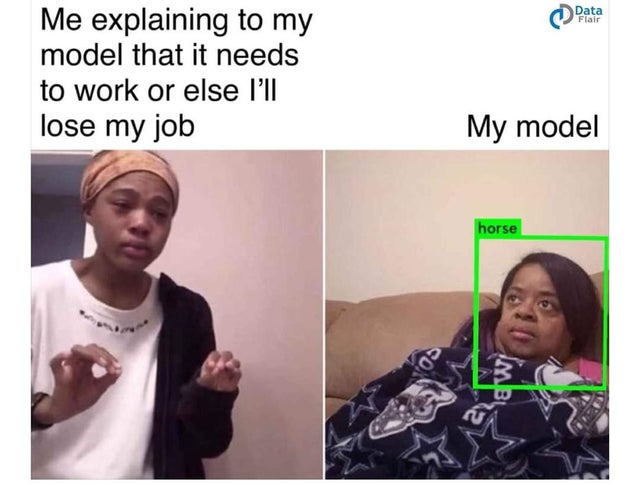